OPTIMISATION : CALIFORNIA HOUSING PRICES (Regression) \
Ce notebook implémente les algorithmes d'optimisation suivants :
1. Descente de Gradient (GD)
2. Gradient Conjugué (CG)
3. Gradient Stochastique (SGD)
4. RMSProp
5. Adam
6. FISTA (avec régularisation L1)

Objectif : Prédiction optimale du prix médian des maisons en Californie

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

CHARGEMENT ET OBSERVATION DES DONNEES

In [5]:
df = pd.read_csv('housing.csv')

print(f"\n Shape du dataset : {df.shape}")
print(f" {df.shape[0]} exemples")
print(f" {df.shape[1]} colonnes")

print("\n Aperçu des données :")
print(df.head(10))

print("\n Informations sur les colonnes :")
print(df.info())


 Shape du dataset : (20640, 10)
 20640 exemples
 10 colonnes

 Aperçu des données :
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   
9    -122.25     37.84                52.0       3549.0           707.0   

   population  households  median_income  median_house_value ocean_proximity  
0       32

EXPLORATION DES DONNEES

In [6]:
# Variable cible 
target = 'median_house_value'

In [7]:
# Analyse de la colonne 'ocean_proximity' (seule variable categorielle)
print(df['ocean_proximity'].value_counts())
print(f"\nNombre de catégories : {df['ocean_proximity'].nunique()}")


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Nombre de catégories : 5


In [8]:
# Valeurs manquantes
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_table = pd.DataFrame({
    'Colonne': missing.index,
    'Valeurs manquantes': missing.values,
    'Pourcentage (%)': missing_pct.values
})
print(missing_table[missing_table['Valeurs manquantes'] > 0])

if missing.sum() == 0:
    print("✓ Aucune valeur manquante détectée !")
else:
    print(f"\n  Total de valeurs manquantes : {missing.sum()}")


          Colonne  Valeurs manquantes  Pourcentage (%)
4  total_bedrooms                 207         1.002907

  Total de valeurs manquantes : 207


NETTOYAGE DES DONNEES

In [9]:
# Traitement des valeurs manquantes
median_bedrooms = df['total_bedrooms'].median()
df['total_bedrooms'].fillna(median_bedrooms, inplace=True)
print(f" Imputation effectuée avec la médiane : {median_bedrooms}")

# Vérification après imputation
df.isnull().sum()

 Imputation effectuée avec la médiane : 435.0


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:
# Encoder la variable catégorielle 'ocean_proximity' (One-Hot Encoding)
ocean_dummies = pd.get_dummies(df['ocean_proximity'], prefix='ocean', drop_first=True)
df = pd.concat([df, ocean_dummies], axis=1)
df = df.drop('ocean_proximity', axis=1)
print(f" {len(ocean_dummies.columns)} nouvelles colonnes créées")
print(f" Colonnes : {list(ocean_dummies.columns)}")

 4 nouvelles colonnes créées
 Colonnes : ['ocean_INLAND', 'ocean_ISLAND', 'ocean_NEAR BAY', 'ocean_NEAR OCEAN']


In [11]:
# Separation des donnees
y = df[target].values
X = df.drop(columns=[target]).values

print(f" Shape de X (features)    : {X.shape}")
print(f" Shape de y (target)      : {y.shape}")

 Shape de X (features)    : (20640, 12)
 Shape de y (target)      : (20640,)


In [12]:
# Separation train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n Shape de X_train : {X_train.shape}")
print(f" Shape de X_test  : {X_test.shape}")
print(f" Shape de y_train : {y_train.shape}")
print(f" Shape de y_test  : {y_test.shape}")


 Shape de X_train : (16512, 12)
 Shape de X_test  : (4128, 12)
 Shape de y_train : (16512,)
 Shape de y_test  : (4128,)


In [32]:
# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

VISUALISATION DES DONNEES

Figure sauvegardée : correlation_matrix.png


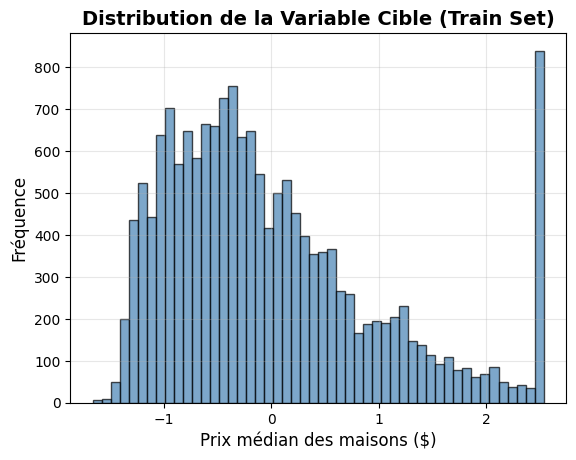

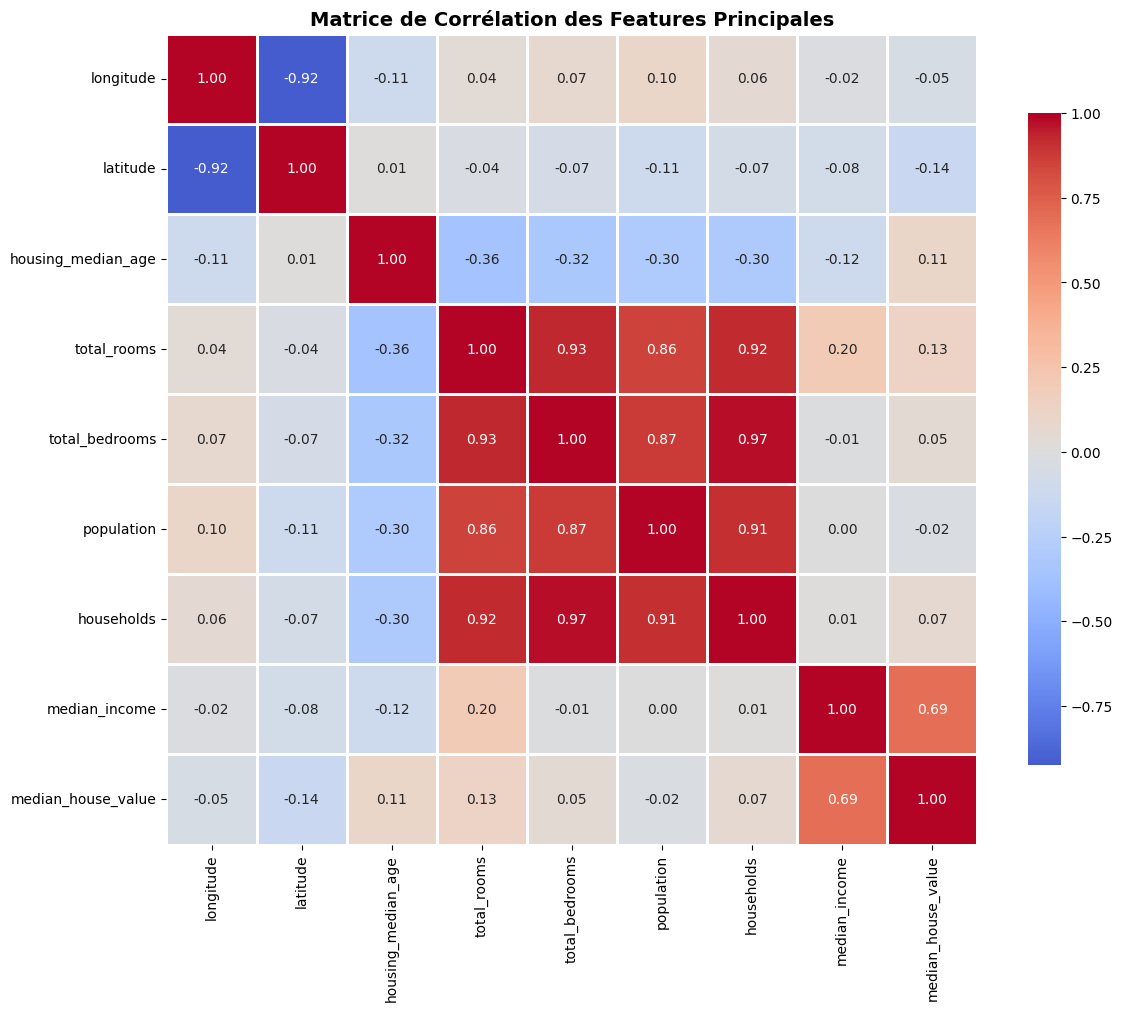

Corrélations les plus fortes avec la target :
  1. median_income             :  0.688
  2. total_rooms               :  0.134
  3. housing_median_age        :  0.106
  4. households                :  0.066
  5. total_bedrooms            :  0.049
  6. population                : -0.025
  7. longitude                 : -0.046
  8. latitude                  : -0.144


In [33]:

plt.hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Prix médian des maisons ($)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.title('Distribution de la Variable Cible (Train Set)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

fig, ax = plt.subplots(figsize=(12, 10))
corr_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                 'total_bedrooms', 'population', 'households', 'median_income', 
                 target]
df_corr = df[corr_features]
corr_matrix = df_corr.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matrice de Corrélation des Features Principales', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Figure sauvegardée : correlation_matrix.png")
plt.show()

print("Corrélations les plus fortes avec la target :")
target_corr = corr_matrix[target].drop(target).sort_values(ascending=False)
for i, (feature, corr) in enumerate(target_corr.items(), 1):
    print(f"  {i}. {feature:25s} : {corr:6.3f}")


PHASE 1 : DESCENTE DE GRADIENT ET GRADIENT CONJUGUE

In [ ]:
# Regression Linéaire avec Régularisation L2 (Ridge Regression)
def compute_loss_l2(X, y, w, lambda_reg):  #F(w)
    n = len(y) 
    predictions = X @ w
    mse = np.sum((predictions - y)**2) / (2 * n)
    reg = (lambda_reg / 2) * np.sum(w**2)
    return mse + reg

def compute_gradient_l2(X, y, w, lambda_reg):
    n = len(y)
    predictions = X @ w
    grad = (X.T @ (predictions - y)) / n + lambda_reg * w
    return grad

def compute_lipschitz_constant(X, lambda_reg):
    n = len(X)
    spectral_norm_sq = np.linalg.norm(X, ord=2)**2
    L = spectral_norm_sq / n + lambda_reg
    return L

def predict(X, w):  #y_pred
    return X @ w

def compute_mse(X, y, w):    #Mean Squared Error
    predictions = predict(X, w)
    return np.mean((predictions - y)**2)


def compute_rmse(X, y, w):     #Root Mean Squared Error
    return np.sqrt(compute_mse(X, y, w))


def compute_r2_score(X, y, w): #Coefficient de détermination R²
    predictions = predict(X, w)
    ss_res = np.sum((y - predictions)**2)
    ss_tot = np.sum((y - y.mean())**2)
    return 1 - (ss_res / ss_tot)


In [35]:
# Descente de gradient a pas fixe avec régularisation L2
def gradient_descent(X, y, lambda_reg, learning_rate=None, max_iter=1000, 
                    tol=1e-6):
    n, d = X.shape
    w = np.zeros(d)
    
    if learning_rate is None:
        L = compute_lipschitz_constant(X, lambda_reg)
        learning_rate = 1.0 / L
    history = {'loss': [], 'grad_norm': [], 'time': []}
    start_time = time.time()
    for k in range(max_iter):
        # Calculer le gradient
        grad = compute_gradient_l2(X, y, w, lambda_reg)
        grad_norm = np.linalg.norm(grad)
        
        # Enregistrer l'historique tous les 10 itérations
        if k % 10 == 0:
            loss = compute_loss_l2(X, y, w, lambda_reg)
            elapsed = time.time() - start_time
            history['loss'].append(loss)
            history['grad_norm'].append(grad_norm)
            history['time'].append(elapsed)
                    
        # Critère d'arrêt
        if grad_norm < tol:
            print(f" Convergence atteinte à l'itération {k} (||Grad(F)||) < {tol})")
            break
        
        # Mise à jour
        w = w - learning_rate * grad
    
    elapsed_total = time.time() - start_time
    print(f" Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f" Loss finale: {compute_loss_l2(X, y, w, lambda_reg):.4f}")
    
    return w, history



In [36]:
lambda_reg = 0.1

w_gd, history_gd = gradient_descent(
    X_train, y_train, 
    lambda_reg=lambda_reg, 
    max_iter=1000, 
    tol=1e-6
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f"  RMSE : {compute_rmse(X_train, y_train, w_gd):.6f}")
print(f"  R²   : {compute_r2_score(X_train, y_train, w_gd):.6f}")


 Convergence atteinte à l'itération 305 (||Grad(F)||) < 1e-06)
 Optimisation terminée en 0.180 secondes
 Loss finale: 0.2098

 Performances sur le train set :
  RMSE : 0.606910
  R²   : 0.631660


In [37]:
lambda_reg = 0.1

w_gd, history_gd = gradient_descent(
    X_train, y_train, 
    lambda_reg=lambda_reg, 
    max_iter=1000, 
    tol=1e-6
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f"  RMSE : {compute_rmse(X_train, y_train, w_gd):.6f}")
print(f"  R²   : {compute_r2_score(X_train, y_train, w_gd):.6f}")


 Convergence atteinte à l'itération 305 (||Grad(F)||) < 1e-06)
 Optimisation terminée en 0.124 secondes
 Loss finale: 0.2098

 Performances sur le train set :
  RMSE : 0.606910
  R²   : 0.631660


In [38]:
#Recherche linéaire (Armijo)
#Trouve le meilleur pas α dans la direction donnée

def line_search_armijo(X, y, w, direction, lambda_reg, alpha_init=1.0, 
                       c=0.5, rho=0.8, max_iter_ls=20):
    alpha = alpha_init
    f0 = compute_loss_l2(X, y, w, lambda_reg)
    grad0 = compute_gradient_l2(X, y, w, lambda_reg)
    slope = grad0 @ direction
    
    for _ in range(max_iter_ls):
        w_new = w + alpha * direction
        f_new = compute_loss_l2(X, y, w_new, lambda_reg)
        
        # Condition d'Armijo
        if f_new <= f0 + c * alpha * slope:
            return alpha
        
        alpha *= rho
    
    return alpha

def conjugate_gradient(X, y, lambda_reg, max_iter=1000, tol=1e-6):
    n, d = X.shape
    w = np.zeros(d)
    
    # Initialiser l'historique
    history = {'loss': [], 'grad_norm': [], 'time': []}
    start_time = time.time()
    
    # Initialisation
    g = compute_gradient_l2(X, y, w, lambda_reg)
    d_k = -g  # Direction initiale = -gradient
    
    for k in range(max_iter):
        grad_norm = np.linalg.norm(g)
        
        # Enregistrer l'historique tous les 10 itérations
        if k % 10 == 0:
            loss = compute_loss_l2(X, y, w, lambda_reg)
            elapsed = time.time() - start_time
            history['loss'].append(loss)
            history['grad_norm'].append(grad_norm)
            history['time'].append(elapsed)
                    
        # Critère d'arrêt
        if grad_norm < tol:
            break
        
        # Recherche linéaire pour trouver le meilleur pas
        alpha = line_search_armijo(X, y, w, d_k, lambda_reg)
        
        # Mise à jour des poids
        w = w + alpha * d_k
        
        # Nouveau gradient
        g_new = compute_gradient_l2(X, y, w, lambda_reg)
        
        # Coefficient beta (formule de Fletcher-Reeves)
        beta = np.dot(g_new, g_new) / np.dot(g, g)
        
        # Nouvelle direction conjuguée
        d_k = -g_new + beta * d_k
        g = g_new

    elapsed_total = time.time() - start_time
    print(f" Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f" Loss finale: {compute_loss_l2(X, y, w, lambda_reg):.4f}")
    
    return w, history

In [39]:
w_cg, history_cg = conjugate_gradient(
    X_train, y_train, 
    lambda_reg=lambda_reg, 
    max_iter=1000, 
    tol=1e-6
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f" RMSE : {compute_rmse(X_train, y_train, w_cg):.6f}")
print(f" R²   : {compute_r2_score(X_train, y_train, w_cg):.6f}")


 Optimisation terminée en 0.131 secondes
 Loss finale: 0.2098

 Performances sur le train set :
 RMSE : 0.606910
 R²   : 0.631660


COMPARAISON DES DEUX METHODES

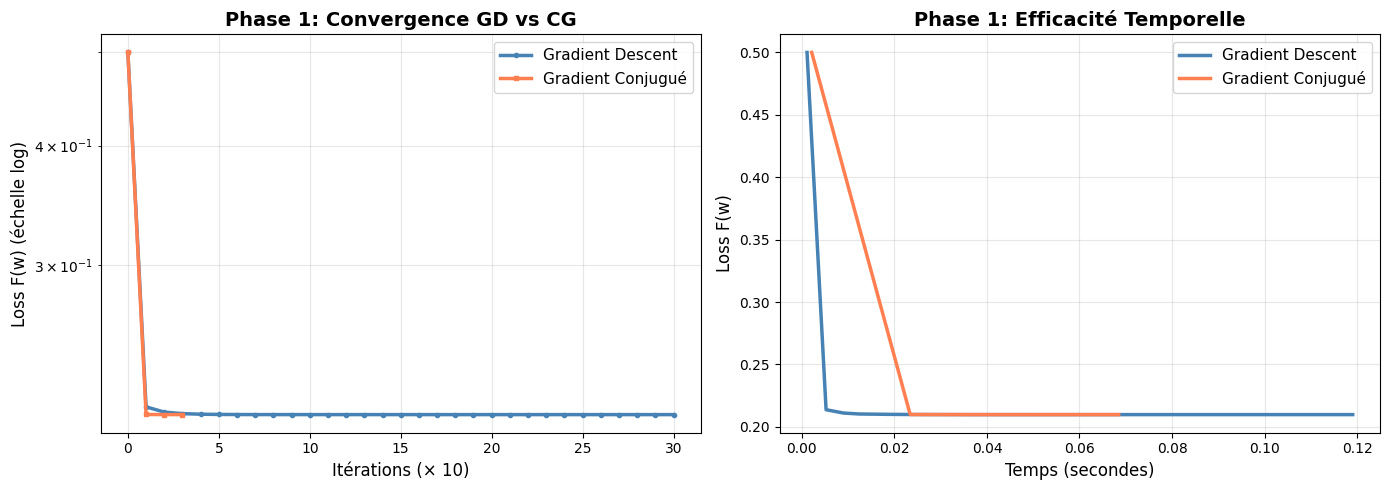

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss vs Itérations
axes[0].semilogy(range(len(history_gd['loss'])), history_gd['loss'], 
                label='Gradient Descent', linewidth=2.5, color='steelblue', 
                marker='o', markersize=3)
axes[0].semilogy(range(len(history_cg['loss'])), history_cg['loss'], 
                label='Gradient Conjugué', linewidth=2.5, color='coral', 
                marker='s', markersize=3)
axes[0].set_xlabel('Itérations (× 10)', fontsize=12)
axes[0].set_ylabel('Loss F(w) (échelle log)', fontsize=12)
axes[0].set_title('Phase 1: Convergence GD vs CG', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, which="both", ls="-", alpha=0.3)

# Loss vs Temps
axes[1].plot(history_gd['time'], history_gd['loss'], 
            label='Gradient Descent', linewidth=2.5, color='steelblue')
axes[1].plot(history_cg['time'], history_cg['loss'], 
            label='Gradient Conjugué', linewidth=2.5, color='coral')
axes[1].set_xlabel('Temps (secondes)', fontsize=12)
axes[1].set_ylabel('Loss F(w)', fontsize=12)
axes[1].set_title('Phase 1: Efficacité Temporelle', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

PHASE 2 : METHODES STOCHASTIQUES

    Les méthodes stochastiques sont essentielles pour les grands datasets :

        • Calcul du gradient sur UN SEUL exemple (ou mini-batch)
        • Complexité O(d) par itération au lieu de O(nd)
        • Convergence plus rapide en pratique
        • Nécessite une décroissance du pas pour garantir la convergence

In [43]:
#Gradient Stochastique avec décroissance du pas
def stochastic_gradient_descent(X, y, lambda_reg, learning_rate=0.1, n_epochs=50):
    n, d = X.shape
    w = np.zeros(d)
    
    # Initialiser l'historique
    history = {'loss': [], 'grad_norm': [], 'time': []}
    start_time = time.time()
    
    k = 0  # Compteur global d'itérations
    
    for epoch in range(n_epochs):
        # Permutation aléatoire des indices (shuffle)
        indices = np.random.permutation(n)
        
        for i in indices:
            # Sélectionner un seul exemple
            xi = X[i:i+1]
            yi = y[i:i+1]
            
            # Calculer le gradient stochastique sur cet exemple
            # ∇f_i(w) = (x_i^T w - y_i) x_i + λw
            pred_i = xi @ w
            grad_i = xi.T @ (pred_i - yi) + lambda_reg * w
            grad_i = grad_i.flatten()
            
            # Calculer le pas adaptatif
            alpha_k = learning_rate / (1 + learning_rate * lambda_reg * k)
            
            # Mise à jour
            w = w - alpha_k * grad_i
            k += 1
        
        # Enregistrer l'historique (une fois par époque)
        loss = compute_loss_l2(X, y, w, lambda_reg)
        grad_full = compute_gradient_l2(X, y, w, lambda_reg)
        grad_norm = np.linalg.norm(grad_full)
        elapsed = time.time() - start_time
        
        history['loss'].append(loss)
        history['grad_norm'].append(grad_norm)
        history['time'].append(elapsed)

    elapsed_total = time.time() - start_time
    print(f"  ✓ Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f"  ✓ Loss finale: {loss:.6f}")

    return w, history

w_sgd, history_sgd = stochastic_gradient_descent(
    X_train, y_train,
    lambda_reg=lambda_reg,
    learning_rate=0.1,
    n_epochs=50
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f"  RMSE : {compute_rmse(X_train, y_train, w_sgd):.6f}")
print(f"  R²   : {compute_r2_score(X_train, y_train, w_sgd):.6f}")

  ✓ Optimisation terminée en 24.227 secondes
  ✓ Loss finale: 0.209809

 Performances sur le train set :
  RMSE : 0.606928
  R²   : 0.631639


In [44]:
# Optimiseur RMSProp (Root Mean Square Propagation)
def rmsprop(X, y, lambda_reg, learning_rate=0.001, beta=0.9, epsilon=1e-8, 
            n_epochs=50):
    n, d = X.shape
    w = np.zeros(d)
    v = np.zeros(d)  # Moyenne mobile des gradients au carré
    
    # Initialiser l'historique
    history = {'loss': [], 'grad_norm': [], 'time': []}
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # Permutation aléatoire
        indices = np.random.permutation(n)
        
        for i in indices:
            # Sélectionner un exemple
            xi = X[i:i+1]
            yi = y[i:i+1]
            
            # Gradient stochastique
            pred_i = xi @ w
            grad_i = xi.T @ (pred_i - yi) + lambda_reg * w
            grad_i = grad_i.flatten()
            
            # Mise à jour de la moyenne mobile des gradients au carré
            v = beta * v + (1 - beta) * grad_i**2
            
            # Mise à jour des poids (division élément par élément)
            w = w - learning_rate * grad_i / (np.sqrt(v) + epsilon)
        
        # Enregistrer l'historique
        loss = compute_loss_l2(X, y, w, lambda_reg)
        grad_full = compute_gradient_l2(X, y, w, lambda_reg)
        grad_norm = np.linalg.norm(grad_full)
        elapsed = time.time() - start_time
        
        history['loss'].append(loss)
        history['grad_norm'].append(grad_norm)
        history['time'].append(elapsed)
        
   
    elapsed_total = time.time() - start_time
    print(f" Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f" Loss finale: {loss:.6f}")
    
    return w, history

w_rmsprop, history_rmsprop = rmsprop(
    X_train, y_train,
    lambda_reg=lambda_reg,
    learning_rate=0.001,
    beta=0.9,
    epsilon=1e-8,
    n_epochs=50
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f" RMSE : {compute_rmse(X_train, y_train, w_rmsprop):.6f}")
print(f" R²   : {compute_r2_score(X_train, y_train, w_rmsprop):.6f}")


 Optimisation terminée en 8.647 secondes
 Loss finale: 0.212681

 Performances sur le train set :
 RMSE : 0.616837
 R²   : 0.619512


In [45]:
# Adam (Adaptive Moment Estimation)")
def adam(X, y, lambda_reg, learning_rate=0.001, beta1=0.9, beta2=0.999, 
         epsilon=1e-8, n_epochs=50):
    n, d = X.shape
    w = np.zeros(d)
    m = np.zeros(d)  # Premier moment (momentum)
    v = np.zeros(d)  # Second moment (variance)
    
    # Initialiser l'historique
    history = {'loss': [], 'grad_norm': [], 'time': []}
    start_time = time.time()
    
    t = 0  # Compteur d'itérations (pour la correction de biais)
    
    for epoch in range(n_epochs):
        # Permutation aléatoire
        indices = np.random.permutation(n)
        
        for i in indices:
            t += 1
            
            # Sélectionner un exemple
            xi = X[i:i+1]
            yi = y[i:i+1]
            
            # Gradient stochastique
            pred_i = xi @ w
            grad_i = xi.T @ (pred_i - yi) + lambda_reg * w
            grad_i = grad_i.flatten()
            
            # Mise à jour des moments
            m = beta1 * m + (1 - beta1) * grad_i
            v = beta2 * v + (1 - beta2) * grad_i**2
            
            # Correction de biais
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            
            # Mise à jour des poids
            w = w - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Enregistrer l'historique
        loss = compute_loss_l2(X, y, w, lambda_reg)
        grad_full = compute_gradient_l2(X, y, w, lambda_reg)
        grad_norm = np.linalg.norm(grad_full)
        elapsed = time.time() - start_time
        
        history['loss'].append(loss)
        history['grad_norm'].append(grad_norm)
        history['time'].append(elapsed)
    
    elapsed_total = time.time() - start_time
    print(f"  ✓ Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f"  ✓ Loss finale: {loss:.6f}")
    
    return w, history

w_adam, history_adam = adam(
    X_train, y_train,
    lambda_reg=lambda_reg,
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    n_epochs=50
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f" RMSE : {compute_rmse(X_train, y_train, w_adam):.6f}")
print(f" R²   : {compute_r2_score(X_train, y_train, w_adam):.6f}")

  ✓ Optimisation terminée en 12.541 secondes
  ✓ Loss finale: 0.211767

 Performances sur le train set :
 RMSE : 0.611776
 R²   : 0.625731


COMPARAISON DES MÉTHODES STOCHASTIQUES

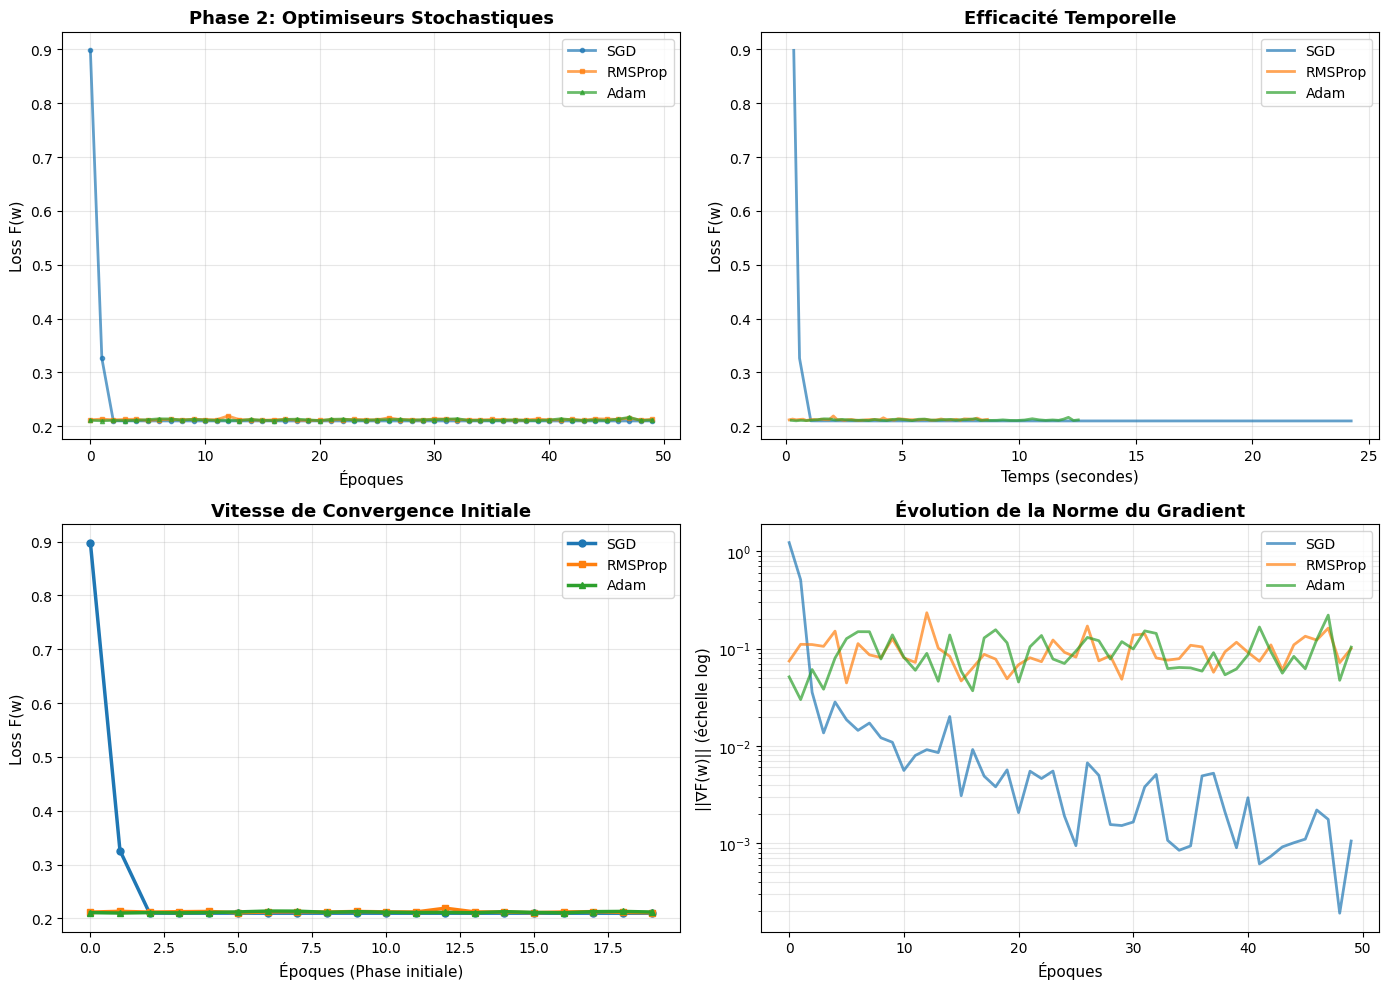

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sous-graphique 1: Loss vs Époques
axes[0, 0].plot(range(len(history_sgd['loss'])), history_sgd['loss'], 
                label='SGD', linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[0, 0].plot(range(len(history_rmsprop['loss'])), history_rmsprop['loss'], 
                label='RMSProp', linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 0].plot(range(len(history_adam['loss'])), history_adam['loss'], 
                label='Adam', linewidth=2, marker='^', markersize=3, alpha=0.7)
axes[0, 0].set_xlabel('Époques', fontsize=11)
axes[0, 0].set_ylabel('Loss F(w)', fontsize=11)
axes[0, 0].set_title('Phase 2: Optimiseurs Stochastiques', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Sous-graphique 2: Loss vs Temps
axes[0, 1].plot(history_sgd['time'], history_sgd['loss'], 
                label='SGD', linewidth=2, alpha=0.7)
axes[0, 1].plot(history_rmsprop['time'], history_rmsprop['loss'], 
                label='RMSProp', linewidth=2, alpha=0.7)
axes[0, 1].plot(history_adam['time'], history_adam['loss'], 
                label='Adam', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Temps (secondes)', fontsize=11)
axes[0, 1].set_ylabel('Loss F(w)', fontsize=11)
axes[0, 1].set_title('Efficacité Temporelle', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Sous-graphique 3: Convergence (premières époques)
n_early = min(20, len(history_sgd['loss']))
axes[1, 0].plot(range(n_early), history_sgd['loss'][:n_early], 
                label='SGD', linewidth=2.5, marker='o', markersize=5)
axes[1, 0].plot(range(n_early), history_rmsprop['loss'][:n_early], 
                label='RMSProp', linewidth=2.5, marker='s', markersize=5)
axes[1, 0].plot(range(n_early), history_adam['loss'][:n_early], 
                label='Adam', linewidth=2.5, marker='^', markersize=5)
axes[1, 0].set_xlabel('Époques (Phase initiale)', fontsize=11)
axes[1, 0].set_ylabel('Loss F(w)', fontsize=11)
axes[1, 0].set_title('Vitesse de Convergence Initiale', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Sous-graphique 4: Norme du gradient
axes[1, 1].semilogy(range(len(history_sgd['grad_norm'])), history_sgd['grad_norm'], 
                    label='SGD', linewidth=2, alpha=0.7)
axes[1, 1].semilogy(range(len(history_rmsprop['grad_norm'])), history_rmsprop['grad_norm'], 
                    label='RMSProp', linewidth=2, alpha=0.7)
axes[1, 1].semilogy(range(len(history_adam['grad_norm'])), history_adam['grad_norm'], 
                    label='Adam', linewidth=2, alpha=0.7)
axes[1, 1].set_xlabel('Époques', fontsize=11)
axes[1, 1].set_ylabel('||∇F(w)|| (échelle log)', fontsize=11)
axes[1, 1].set_title('Évolution de la Norme du Gradient', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, which="both", ls="-", alpha=0.3)

plt.tight_layout()
plt.show()

PHASE 3 : MÉTHODES PROXIMALES

    • Sélection automatique de variables (coefficients = 0)
    • Modèle interprétable (peu de features actives)
    • Utile en haute dimension (d >> n)

In [49]:
# Regularisation L1
def compute_loss_l1(X, y, w, lambda_reg):
    n = len(y)
    predictions = X @ w
    mse = np.sum((predictions - y)**2) / (2 * n)
    l1_penalty = lambda_reg * np.sum(np.abs(w))
    return mse + l1_penalty

# Calcul du gradient de la partie LISSE uniquement
def compute_gradient_smooth(X, y, w):
    n = len(y)
    predictions = X @ w
    grad = (X.T @ (predictions - y)) / n
    return grad

# Opérateur proximal de la norme L1
def soft_threshold(v, threshold):
    return np.sign(v) * np.maximum(np.abs(v) - threshold, 0)

# Parcimonie : calcule le nombre de coefficients non nuls

def compute_sparsity(w, tol=1e-6):
    return np.sum(np.abs(w) > tol)


In [51]:
# ISTA : Iterative Soft-Thresholding Algorithm
def ista(X, y, lambda_reg, learning_rate=None, max_iter=500, tol=1e-6):
    n, d = X.shape
    w = np.zeros(d)
    
    # Calculer le pas (basé sur Lipschitz de la partie lisse f)
    if learning_rate is None:
        spectral_norm_sq = np.linalg.norm(X, ord=2)**2
        L_f = spectral_norm_sq / n
        learning_rate = 1.0 / L_f
    
    # Initialiser l'historique
    history = {'loss': [], 'sparsity': [], 'time': []}
    start_time = time.time()
    
    for k in range(max_iter):
        # Étape 1 : Pas de gradient sur la partie lisse
        grad_f = compute_gradient_smooth(X, y, w)
        v = w - learning_rate * grad_f
        
        # Étape 2 : Opérateur proximal (seuillage doux)
        threshold = learning_rate * lambda_reg
        w_new = soft_threshold(v, threshold)
        
        # Enregistrer l'historique tous les 10 itérations
        if k % 10 == 0:
            loss = compute_loss_l1(X, y, w_new, lambda_reg)
            sparsity = compute_sparsity(w_new)
            elapsed = time.time() - start_time
            
            history['loss'].append(loss)
            history['sparsity'].append(sparsity)
            history['time'].append(elapsed)
                    
        # Critère d'arrêt (changement relatif de la loss)
        if k > 0 and len(history['loss']) >= 2:
            rel_change = abs(history['loss'][-1] - history['loss'][-2])
            if rel_change < tol:
                break
        
        w = w_new
    
    elapsed_total = time.time() - start_time
    final_loss = compute_loss_l1(X, y, w, lambda_reg)
    final_sparsity = compute_sparsity(w)
    print(f"  Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f"  Loss finale : {final_loss:.6f}")
    print(f"  Parcimonie finale : {final_sparsity}/{d} coefficients non nuls")

    return w, history

lambda_l1 = 0.01

w_ista, history_ista = ista(
    X_train, y_train,
    lambda_reg=lambda_l1,
    max_iter=500,
    tol=1e-6
)

# Évaluation
print(f"\n Performances sur le train set :")
print(f" RMSE : {compute_rmse(X_train, y_train, w_ista):.6f}")
print(f" R²   : {compute_r2_score(X_train, y_train, w_ista):.6f}")


  Optimisation terminée en 0.044 secondes
  Loss finale : 0.199256
  Parcimonie finale : 10/12 coefficients non nuls

 Performances sur le train set :
 RMSE : 0.599351
 R²   : 0.640779


In [52]:
# FISTA : Fast Iterative Soft-Thresholding Algorithm
def fista(X, y, lambda_reg, learning_rate=None, max_iter=500, tol=1e-6):
    n, d = X.shape
    w = np.zeros(d)
    z = np.zeros(d)  # Point d'extrapolation
    
    # Calculer le pas
    if learning_rate is None:
        spectral_norm_sq = np.linalg.norm(X, ord=2)**2
        L_f = spectral_norm_sq / n
        learning_rate = 1.0 / L_f

    # Initialiser l'historique
    history = {'loss': [], 'sparsity': [], 'time': []}
    start_time = time.time()
    
    t = 1  # Paramètre d'extrapolation
    w_old = w.copy()
    
    for k in range(max_iter):
        # Étape 1 : Pas de gradient au point d'extrapolation z
        grad_f = compute_gradient_smooth(X, y, z)
        v = z - learning_rate * grad_f
        
        # Étape 2 : Opérateur proximal
        threshold = learning_rate * lambda_reg
        w = soft_threshold(v, threshold)
        
        # Étape 3 : Mise à jour du paramètre t
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        
        # Étape 4 : Extrapolation (momentum de Nesterov)
        z = w + ((t - 1) / t_new) * (w - w_old)
        
        # Enregistrer l'historique tous les 10 itérations
        if k % 10 == 0:
            loss = compute_loss_l1(X, y, w, lambda_reg)
            sparsity = compute_sparsity(w)
            elapsed = time.time() - start_time
            
            history['loss'].append(loss)
            history['sparsity'].append(sparsity)
            history['time'].append(elapsed)
        
        # Critère d'arrêt
        if k > 0 and len(history['loss']) >= 2:
            rel_change = abs(history['loss'][-1] - history['loss'][-2])
            if rel_change < tol:
                break
        
        # Mise à jour pour l'itération suivante
        w_old = w.copy()
        t = t_new
    
    elapsed_total = time.time() - start_time
    final_loss = compute_loss_l1(X, y, w, lambda_reg)
    final_sparsity = compute_sparsity(w)
    print(f" Optimisation terminée en {elapsed_total:.3f} secondes")
    print(f" Loss finale : {final_loss:.6f}")
    print(f" Parcimonie finale : {final_sparsity}/{d} coefficients non nuls")
    
    return w, history


# Test de l'algorithme FISTA
print("\n[Test] Entraînement avec FISTA")

w_fista, history_fista = fista(
    X_train, y_train,
    lambda_reg=lambda_l1,
    max_iter=500,
    tol=1e-6
)

# Évaluation
print(f"\n📊 Performances sur le train set :")
print(f"  RMSE : {compute_rmse(X_train, y_train, w_fista):.6f}")
print(f"  R²   : {compute_r2_score(X_train, y_train, w_fista):.6f}")


[Test] Entraînement avec FISTA
 Optimisation terminée en 0.016 secondes
 Loss finale : 0.199249
 Parcimonie finale : 10/12 coefficients non nuls

📊 Performances sur le train set :
  RMSE : 0.599076
  R²   : 0.641108


COMPARAISON ISTA VS FISTA

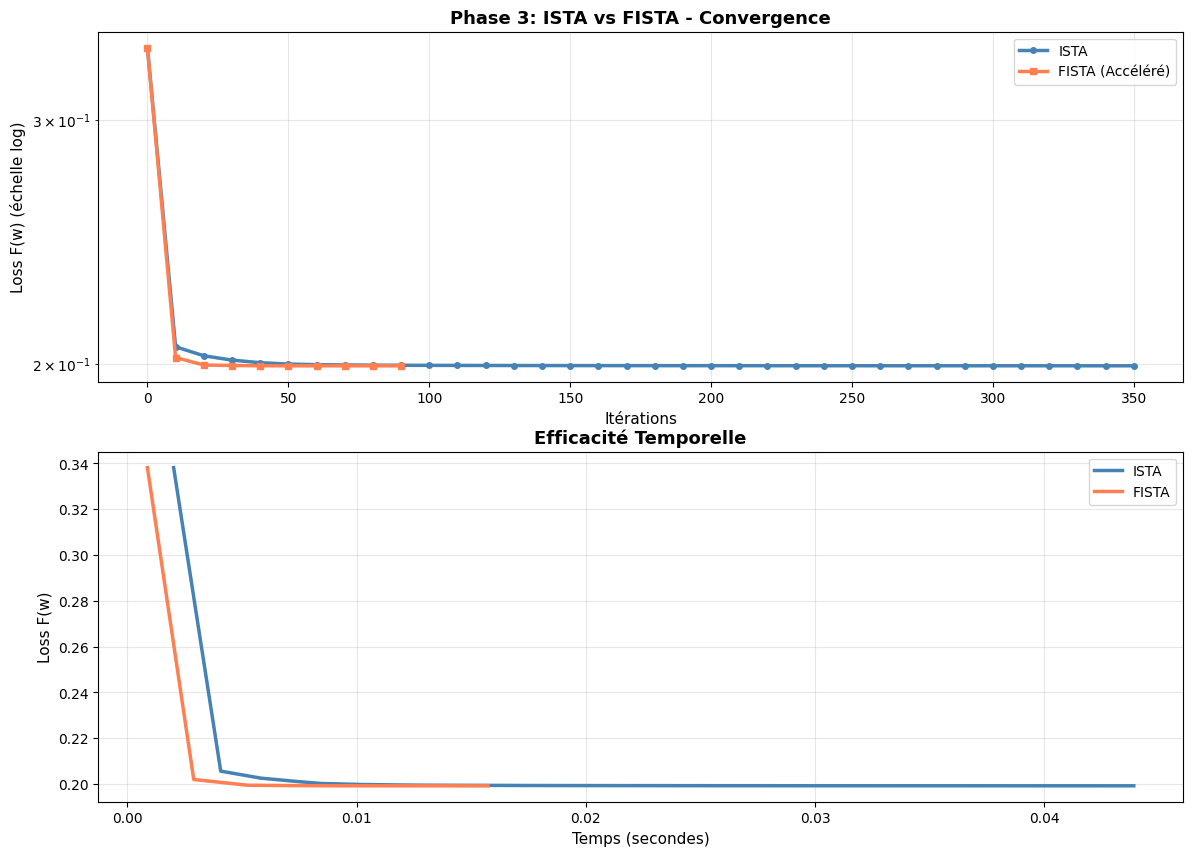

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sous-graphique 1: Loss vs Itérations (échelle log)
iters_ista = np.arange(len(history_ista['loss'])) * 10
iters_fista = np.arange(len(history_fista['loss'])) * 10

axes[0].semilogy(iters_ista, history_ista['loss'], 
                   label='ISTA', linewidth=2.5, marker='o', markersize=4, color='steelblue')
axes[0].semilogy(iters_fista, history_fista['loss'], 
                   label='FISTA (Accéléré)', linewidth=2.5, marker='s', markersize=4, color='coral')
axes[0].set_xlabel('Itérations', fontsize=11)
axes[0].set_ylabel('Loss F(w) (échelle log)', fontsize=11)
axes[0].set_title('Phase 3: ISTA vs FISTA - Convergence', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, which="both", ls="-", alpha=0.3)

# Sous-graphique 2: Loss vs Temps
axes[1].plot(history_ista['time'], history_ista['loss'], 
               label='ISTA', linewidth=2.5, color='steelblue')
axes[1].plot(history_fista['time'], history_fista['loss'], 
               label='FISTA', linewidth=2.5, color='coral')
axes[1].set_xlabel('Temps (secondes)', fontsize=11)
axes[1].set_ylabel('Loss F(w)', fontsize=11)
axes[1].set_title('Efficacité Temporelle', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

IMPACT DE LAMBDA SUR LA PARCIMONIE



Test de différentes valeurs de λ...
 Optimisation terminée en 0.017 secondes
 Loss finale : 0.178050
 Parcimonie finale : 12/12 coefficients non nuls
 Optimisation terminée en 0.012 secondes
 Loss finale : 0.188405
 Parcimonie finale : 11/12 coefficients non nuls
 Optimisation terminée en 0.007 secondes
 Loss finale : 0.199255
 Parcimonie finale : 10/12 coefficients non nuls
 Optimisation terminée en 0.009 secondes
 Loss finale : 0.215873
 Parcimonie finale : 9/12 coefficients non nuls
 Optimisation terminée en 0.006 secondes
 Loss finale : 0.250564
 Parcimonie finale : 4/12 coefficients non nuls
 Optimisation terminée en 0.005 secondes
 Loss finale : 0.293784
 Parcimonie finale : 3/12 coefficients non nuls
 Optimisation terminée en 0.005 secondes
 Loss finale : 0.364638
 Parcimonie finale : 2/12 coefficients non nuls


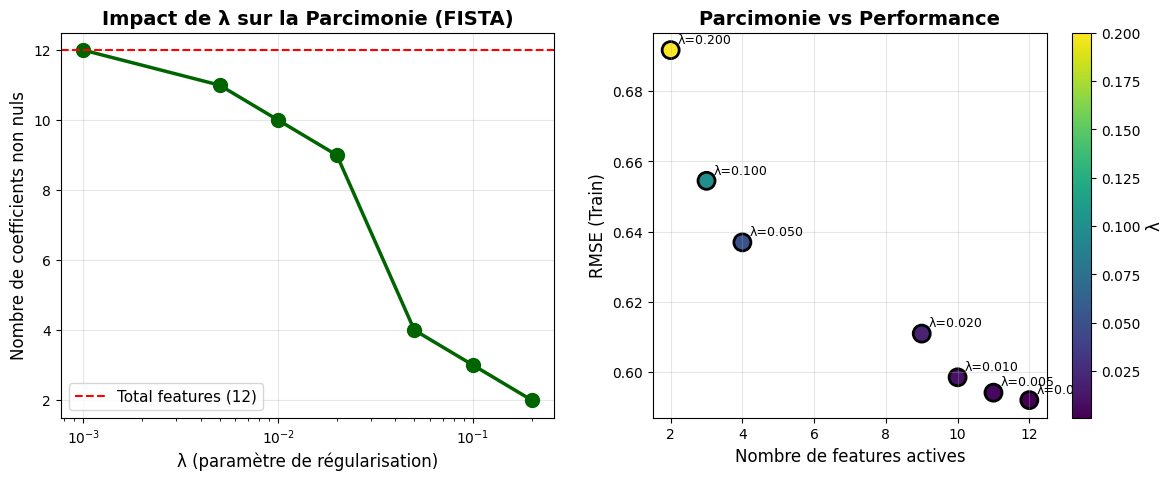

In [61]:
lambdas = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
sparsities_lambda = []
rmses_lambda = []
d = X_train.shape[1]

print("\nTest de différentes valeurs de λ...")
for lam in lambdas:
    w_temp, _ = fista(X_train, y_train, lambda_reg=lam, 
                     max_iter=300, tol=1e-5)
    sparsity = compute_sparsity(w_temp)
    rmse = compute_rmse(X_train, y_train, w_temp)
    sparsities_lambda.append(sparsity)
    rmses_lambda.append(rmse)
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Impact sur la parcimonie
axes[0].plot(lambdas, sparsities_lambda, marker='o', linewidth=2.5, 
            markersize=10, color='darkgreen')
axes[0].set_xlabel('λ (paramètre de régularisation)', fontsize=12)
axes[0].set_ylabel('Nombre de coefficients non nuls', fontsize=12)
axes[0].set_title('Impact de λ sur la Parcimonie (FISTA)', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].axhline(y=d, color='red', linestyle='--', label=f'Total features ({d})', linewidth=1.5)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Trade-off Parcimonie vs Performance
axes[1].scatter(sparsities_lambda, rmses_lambda, s=150, c=lambdas, 
               cmap='viridis', edgecolors='black', linewidth=2)
for i, lam in enumerate(lambdas):
    axes[1].annotate(f'λ={lam:.3f}', (sparsities_lambda[i], rmses_lambda[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1].set_xlabel('Nombre de features actives', fontsize=12)
axes[1].set_ylabel('RMSE (Train)', fontsize=12)
axes[1].set_title('Parcimonie vs Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('λ', fontsize=12)

plt.show()